In [1]:
# to add the root path to sys.path so that we can import the modules we have created
import os
import sys
module_path = os.path.abspath(os.path.join('..'))
if module_path not in sys.path:
    sys.path.append(module_path)
    print('Added root path to sys.path')

Added root path to sys.path


In [2]:
# general imports
import utils
import torch
import torch.nn as nn
import numpy as np
import matplotlib.pyplot as plt
import scienceplots
plt.style.use(['science', 'grid', 'no-latex'])

## Import Data

Import data from the utils module. Then we check the shape of the data. After that we plot two samples to see how the data looks like.

In [3]:
mnist = utils.get_data("mnist")
data = next(iter(mnist['train_dl']))
images, labels = data

In [4]:
images.shape, labels.shape

(torch.Size([128, 1, 28, 28]), torch.Size([128]))

(<matplotlib.image.AxesImage at 0x28ba9ffd0>, tensor(8))

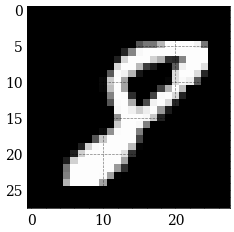

In [5]:
plt.imshow(images[0].squeeze(), cmap='gray'), labels[0]

(<matplotlib.image.AxesImage at 0x291831570>, tensor(4))

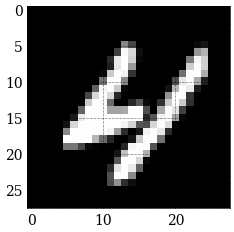

In [6]:
plt.imshow(images[1].squeeze(), cmap='gray'), labels[1]

## GAN

A Generative Adversarial Network (GAN) is composed of two components: a generator and a discriminator.

The generator is a neural network that takes a random vector as input and outputs a sample from the data distribution.

The discriminator is a neural network that takes a sample from the data distribution as input and outputs a probability that the sample is real.

The generator and discriminator are trained simultaneously. The generator is trained to fool the discriminator, and the discriminator is trained to distinguish between real and fake samples.

The generator and discriminator are trained in an adversarial manner. The generator is trained to maximize the probability of the discriminator making a mistake. The discriminator is trained to maximize the probability of correctly classifying real and fake samples.

The optimization problem for the generator is:

![GAN](../images/gans_cost.png)

This is read as: train G to minimize the cost function V and train D to maximize the cost function V.

Where:
    1. D(x) is the probability that x comes from the real data distribution.
    2. D(G(z)) is the probability that G(z) comes from the data distribution.
    3. G(z) is the output of the generator when given a random vector z.

Latent Dimension:

In [7]:
latent_dim = 100

Descriminator:

In [8]:
class Discriminator(nn.Module):
    def __init__(self, input_dim) -> None:
        super().__init__()
        
        self.model = nn.Sequential(
            nn.Linear(input_dim, 128),
            nn.LeakyReLU(0.2),
            nn.Dropout(0.3),
            
            nn.Linear(128, 64),
            nn.LeakyReLU(0.2),
            nn.Dropout(0.3),
            
            nn.Linear(64, 1),
            nn.Sigmoid()
        )
        
    def forward(self, x):
        return self.model(x)

discriminator = Discriminator(input_dim=images[0].numel())

Generator:

In [9]:
class Generator(nn.Module):
    def __init__(self, hidden_dim, output_dim) -> None:
        super().__init__()
        
        self.model = nn.Sequential(
            nn.Linear(hidden_dim, 128),
            nn.LeakyReLU(0.2),
            
            nn.Linear(128, 256),
            nn.LeakyReLU(0.2),
            
            nn.Linear(256, output_dim),
            nn.LeakyReLU(0.2)
        )
        
    def forward(self, x):
        return self.model(x)

generator = Generator(hidden_dim=latent_dim, output_dim=images[0].numel())

Critereon:

In [10]:
critereon = nn.BCELoss()

Optimizer:

In [11]:
optD = torch.optim.Adam(discriminator.parameters(), lr=3e-4)
optG = torch.optim.Adam(generator.parameters(), lr=3e-4)

Training:

In [12]:
epochs = 100
train_dl = mnist['train_dl']
val_dl = mnist['val_dl']
test_dl = mnist['test_dl']
real_label = 1
fake_label = 0

In [13]:
train_d_losses = []
train_g_losses = []

for epoch in range(epochs):
    # train
    for data in train_dl:
        x, _ = data
        x = x.squeeze().view(x.shape[0], -1)
        z = torch.randn(x.shape[0], latent_dim)
        fake_x = generator(z)
        real_y = torch.full((x.shape[0],1), real_label).float()
        fake_y = torch.full((x.shape[0],1), fake_label).float()
        
        # train discriminator
        # (1) Update D network: maximize log(D(x)) + log(1 - D(G(z)))
        optD.zero_grad()
        real_pred = discriminator(x)
        real_loss = critereon(real_pred, real_y)
        real_loss.backward()
        
        fake_pred = discriminator(fake_x.detach())
        fake_loss = critereon(fake_pred, fake_y)
        fake_loss.backward()

        optD.step()
        
        d_loss = real_loss.item() + fake_loss.item()
        train_d_losses.append(d_loss)
        
        # train generator
        # (2) Update G network: maximize log(D(G(z))), this minimizes log(1 - D(G(z)))
        generator.zero_grad()
        fake_pred = discriminator(fake_x)
        fake_loss = critereon(fake_pred, real_y)
        fake_loss.backward()
        optG.step()
        
        g_loss = fake_loss.item()
        train_g_losses.append(g_loss)
    
    print(f'Epoch: {epoch+1}/{epochs}, D_loss: {np.mean(train_d_losses):.4f}, G_loss: {np.mean(train_g_losses):.4f}')

Epoch: 1/100, D_loss: 0.9749, G_loss: 1.1219
Epoch: 2/100, D_loss: 0.7873, G_loss: 1.4096
Epoch: 3/100, D_loss: 0.7155, G_loss: 1.7748
Epoch: 4/100, D_loss: 0.6624, G_loss: 1.9672
Epoch: 5/100, D_loss: 0.6538, G_loss: 2.0726
Epoch: 6/100, D_loss: 0.6353, G_loss: 2.1538
Epoch: 7/100, D_loss: 0.6258, G_loss: 2.2323
Epoch: 8/100, D_loss: 0.6299, G_loss: 2.2358
Epoch: 9/100, D_loss: 0.6350, G_loss: 2.2405
Epoch: 10/100, D_loss: 0.6385, G_loss: 2.2367
Epoch: 11/100, D_loss: 0.6465, G_loss: 2.2158
Epoch: 12/100, D_loss: 0.6535, G_loss: 2.1973
Epoch: 13/100, D_loss: 0.6612, G_loss: 2.1777
Epoch: 14/100, D_loss: 0.6759, G_loss: 2.1476
Epoch: 15/100, D_loss: 0.6901, G_loss: 2.1146
Epoch: 16/100, D_loss: 0.7061, G_loss: 2.0797
Epoch: 17/100, D_loss: 0.7172, G_loss: 2.0511
Epoch: 18/100, D_loss: 0.7295, G_loss: 2.0220
Epoch: 19/100, D_loss: 0.7384, G_loss: 1.9980
Epoch: 20/100, D_loss: 0.7512, G_loss: 1.9744
Epoch: 21/100, D_loss: 0.7616, G_loss: 1.9491
Epoch: 22/100, D_loss: 0.7730, G_loss: 1.92

In [23]:
random_z = torch.randn(1, latent_dim)
sample = generator(random_z)

In [24]:
sample = sample.view(28, 28).detach().numpy()

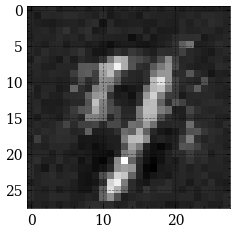

In [25]:
plt.imshow(sample, cmap='gray')

This was just a demo. It is recommended to use much complex models for better results.